### Estimating Planetary Radii in Four Directions from Transit Light Curves calculated with Catwoman (Jones & Espinoza 2020; Espinoza & Jones 2021)

In [2]:
from wasp39b_params import period_day
from calc_light_curve import transit_compute_flux_ecc0
from karate.calc_contact_times import (
    calc_contact_times_circular,
)
from karate.convert_ctv import (
    contact_times_to_delta_c_ingress_circular,
    contact_times_to_delta_c_egress_circular,
    rotate_delta_c_egress_circular,
    rotate_delta_c_ingress_circular,
    dcx_to_rp_spectra,
)

import numpy as np
import matplotlib.pyplot as plt

import catwoman

from jax import random
from jax import config
import jax.numpy as jnp

import numpyro
from numpyro import distributions as dist
from numpyro.infer import Predictive
from numpyro.infer import MCMC, NUTS, init_to_value
from numpyro.diagnostics import hpdi

config.update("jax_enable_x64", True)

Generate a transit light curve where the planetary radii differ between the morning and evening limbs. Each side is assumed to have a different wavelength dependence.

In [3]:
rng_key = random.key(0)
rng_key, rng_key_ = random.split(rng_key)

wavelength = np.linspace(3.0, 5.0, 21)
time = np.linspace(-150, 150, 301) * 65
rp_over_rs_evening = 0.150 + 0.005 * np.sin(wavelength * np.pi)
rp_over_rs_morning = 0.150 + 0.005 * np.sin(wavelength * np.pi * 1.6 + np.pi * 0.5)
t0 = 0
period = period_day * 24 * 60 * 60
a_over_rs = 11.4
ecc = 0
omega = 0
cosi = 0.45 / a_over_rs
u1 = 0.1
u2 = 0.1
jitter = 0.00025

flux = np.zeros((len(rp_over_rs_evening), len(time)))
params = catwoman.TransitParams()  # object to store transit parameters
params.t0 = t0  # time of inferior conjuction (in days)
params.per = period  # orbital period (in days)
params.a = a_over_rs  # semi-major axis (in units of stellar radii)
params.ecc = 0  # eccentricity
params.w = 0  # longitude of periastron (in degrees)
params.inc = np.arccos(cosi) / np.pi * 180.0  # orbital inclination (in degrees)
params.u = [u1, u2]  # limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"  # limb darkening model
params.phi = 90.0  # angle of rotation of top semi-circle
for i in range(len(rp_over_rs_evening)):
    params.rp = rp_over_rs_evening[i]  # top semi-circle radius (in units of stellar radii)
    params.rp2 = rp_over_rs_morning[i]  # bottom semi-circle radius (in units of stellar radii)

    model_catwoman = catwoman.TransitModel(params, time)  # initalises model
    flux[i] = model_catwoman.light_curve(params)  # calculates light curve

error = jitter * random.normal(rng_key_, shape=flux.shape)
flux = flux + error


The spectra for both the morning and evening limbs

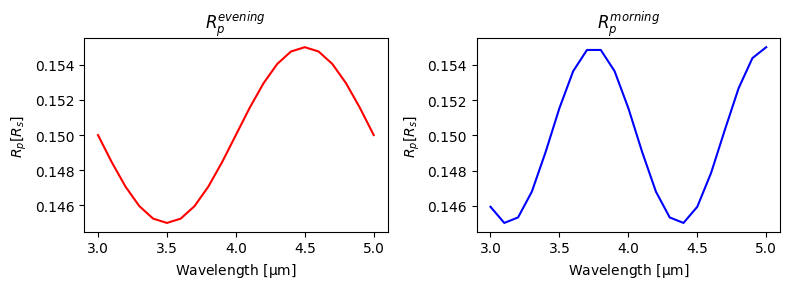

In [4]:
%matplotlib inline
rp_truth = [rp_over_rs_evening, rp_over_rs_morning]
directions = ["$R_{p}^{evening}$", "$R_{p}^{morning}$"]
color = ["red", "blue"]
fig = plt.figure(figsize=(8,3))
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    ax.plot(
        wavelength,
        rp_truth[i],
        color=color[i],
    )
    ax.set_title(directions[i])
    ax.set_xlabel("Wavelength [$\mathrm{\mu m}$]")
    ax.set_ylabel("$R_{p} [R_{s}]$")
plt.tight_layout()
plt.show()
plt.close()

The generated data will be fitted with a transit light curve assuming zero eccentricity using Numpyro's Hamiltonian Monte Carlo (HMC).

In [5]:
def model_ecc0(flux_obs, time, num_lightcurve):
    with numpyro.plate("n_light_curve", num_lightcurve, dim=-1):
        period = period_day * 24 * 60 * 60
        t0 = numpyro.sample("t0", dist.Uniform(-5000, 5000))
        depth = numpyro.sample("depth", dist.Uniform(0, 0.1))
        Ttot = numpyro.sample("Ttot", dist.Uniform(5000, 15000))

        theta_tot = 2 * jnp.pi * Ttot / period
        theta_full_max = 2 * jnp.arcsin(
            (1 - jnp.sqrt(depth)) / (1 + jnp.sqrt(depth)) * jnp.sin(theta_tot / 2)
        )
        Tfull_max = theta_full_max / 2 / jnp.pi * period
        Tfull = numpyro.sample("Tfull", dist.Uniform(1, Tfull_max))
        theta_full = 2 * jnp.pi * Tfull / period

        u1 = numpyro.sample("u1", dist.Uniform(-3, 3))
        u2 = numpyro.sample("u2", dist.Uniform(-3, 3))
        baseline = numpyro.sample("baseline", dist.Uniform(0.99, 1.01))
        jitter = numpyro.sample("jitter", dist.Uniform(0, 0.01))

    rp_over_rs = jnp.sqrt(depth)
    a_over_rs = jnp.sqrt(
        (
            -((1 - jnp.sqrt(depth)) ** 2) * jnp.cos(theta_tot / 2) ** 2
            + (1 + jnp.sqrt(depth)) ** 2 * jnp.cos(theta_full / 2) ** 2
        )
        / jnp.sin((theta_tot + theta_full) / 2)
        / jnp.sin((theta_tot - theta_full) / 2)
    )
    cosi = jnp.sqrt(
        (
            (1 - jnp.sqrt(depth)) ** 2 * jnp.sin(theta_tot / 2) ** 2
            - (1 + jnp.sqrt(depth)) ** 2 * jnp.sin(theta_full / 2) ** 2
        )
        / (
            -((1 - jnp.sqrt(depth)) ** 2) * jnp.cos(theta_tot / 2) ** 2
            + (1 + jnp.sqrt(depth)) ** 2 * jnp.cos(theta_full / 2) ** 2
        )
    )
    flux = transit_compute_flux_ecc0(
        time, rp_over_rs, t0, period, a_over_rs, cosi, u1, u2
    )
    with numpyro.plate("wavelength", num_lightcurve, dim=-2):
        with numpyro.plate("time", len(time), dim=-1):
            numpyro.sample(
                "light_curve",
                dist.Normal(
                    flux * baseline[:, None],
                    jitter[:, None] * jnp.ones_like(flux),
                ),
                obs=flux_obs,
            )

In [6]:
init_Ttot = (
    period
    / jnp.pi
    * jnp.arcsin(
        jnp.sqrt((1.0 + 0.15) ** 2 - (a_over_rs * cosi) ** 2)
        / jnp.sqrt(1.0 - cosi**2)
        / a_over_rs
    )
)
init_Tfull = (
    period
    / jnp.pi
    * jnp.arcsin(
        jnp.sqrt((1.0 - 0.15) ** 2 - (a_over_rs * cosi) ** 2)
        / jnp.sqrt(1.0 - cosi**2)
        / a_over_rs
    )
)
init_values = {
    "t0": t0 * jnp.ones_like(rp_over_rs_evening),
    "Ttot": init_Ttot * jnp.ones_like(rp_over_rs_evening),
    "Tfull": init_Tfull * jnp.ones_like(rp_over_rs_evening),
    "depth": 0.15**2 * jnp.ones_like(rp_over_rs_evening),
    "u1": u1 * jnp.ones_like(rp_over_rs_evening),
    "u2": u2 * jnp.ones_like(rp_over_rs_evening),
    "baseline": 1.0 * jnp.ones_like(rp_over_rs_evening),
    "jitter": jitter * jnp.ones_like(rp_over_rs_evening),
}
init_strategy = init_to_value(values=init_values)

# MCMC
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(model_ecc0, init_strategy=init_strategy)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)
mcmc.run(
    rng_key_,
    flux_obs=flux,
    time=time,
    num_lightcurve=len(flux),
)

# mcmc.print_summary()

# Get samples
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [03:26<00:00,  9.67it/s, 127 steps of size 3.83e-02. acc. prob=0.87]


In [7]:
# Prediction
rng_key, rng_key_ = random.split(rng_key)
pred = Predictive(model_ecc0, posterior_samples)
predictions = pred(
    rng_key_,
    flux_obs=None,
    time=time,
    num_lightcurve=len(flux),
)

Example of a Fitted Light Curve

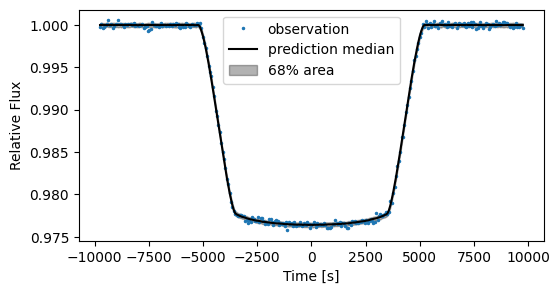

In [8]:
pred_median = np.median(predictions["light_curve"], axis=0)
pred_hpdi = hpdi(predictions["light_curve"], 0.68)

%matplotlib inline
plt.figure(figsize=(6,3))
plt.plot(
    time,
    flux[10],
    marker=".",
    markersize=3,
    linestyle="None",
    label="observation",
)
plt.plot(
    time,
    pred_median[10],
    color="black",
    label="prediction median",
)
plt.fill_between(
    time,
    pred_hpdi[0, 10],
    pred_hpdi[1, 10],
    alpha=0.3,
    interpolate=True,
    color="black",
    label="68% area",
)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Relative Flux")
plt.show()
plt.close()

From the estimated parameters, we will derive the planetary radius, the orbital semi-major axis, cos(orbital inclination), and the transit center time at each wavelength. Using these values, we will compute the contact times and convert them into the spectra of the planetary radius in four directions.

In [9]:
theta_tot = 2 * np.pi * posterior_samples["Ttot"] / period
theta_full = 2 * np.pi * posterior_samples["Tfull"] / period

sample_rp_over_rs = np.sqrt(posterior_samples["depth"])
sample_a_over_rs = np.sqrt(
    (
        -(1 - sample_rp_over_rs) ** 2 * np.cos(theta_tot / 2) ** 2
        + (1 + sample_rp_over_rs) ** 2 * np.cos(theta_full / 2) ** 2
    )
    / np.sin((theta_tot + theta_full) / 2)
    / np.sin((theta_tot - theta_full) / 2)
)
sample_cosi = np.sqrt(
    (
        (1 - sample_rp_over_rs) ** 2 * np.sin(theta_tot / 2) ** 2
        - (1 + sample_rp_over_rs) ** 2 * np.sin(theta_full / 2) ** 2
    )
    / (
        -((1 - sample_rp_over_rs) ** 2) * np.cos(theta_tot / 2) ** 2
        + (1 + sample_rp_over_rs) ** 2 * np.cos(theta_full / 2) ** 2
    )
)
sample_t1, sample_t2, sample_t3, sample_t4 = calc_contact_times_circular(
    sample_rp_over_rs, period, sample_a_over_rs, sample_cosi, posterior_samples["t0"]
)

dc_X_ingress, dc_Y_ingress = contact_times_to_delta_c_ingress_circular(
    sample_rp_over_rs,
    sample_t1,
    sample_t2,
    period,
    np.mean(np.median(sample_a_over_rs, axis=0)),
    np.mean(np.median(sample_cosi, axis=0)),
    np.mean(np.median(posterior_samples["t0"], axis=0)),
    rs_alpha=1,
)
dc_X_egress, dc_Y_egress = contact_times_to_delta_c_egress_circular(
    sample_rp_over_rs,
    sample_t3,
    sample_t4,
    period,
    np.mean(np.median(sample_a_over_rs, axis=0)),
    np.mean(np.median(sample_cosi, axis=0)),
    np.mean(np.median(posterior_samples["t0"], axis=0)),
    rs_alpha=1,
)
dc_xi_ingress, dc_yi_ingress = rotate_delta_c_ingress_circular(
    dc_X_ingress, 
    dc_Y_ingress, 
    np.mean(np.median(sample_a_over_rs, axis=0)),
    np.mean(np.median(sample_cosi, axis=0)),
)
dc_xe_egress, dc_ye_egress = rotate_delta_c_egress_circular(
    dc_X_egress, 
    dc_Y_egress, 
    np.mean(np.median(sample_a_over_rs, axis=0)),
    np.mean(np.median(sample_cosi, axis=0)),
)
rp_xip, rp_xin = dcx_to_rp_spectra(
    sample_rp_over_rs, dc_xi_ingress, rs_alpha=1
)
rp_xep, rp_xen = dcx_to_rp_spectra(
    sample_rp_over_rs, dc_xe_egress, rs_alpha=1
)

The number of d < rs_alpha*k (ingress) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
The number of d < rs_alpha*k (egress) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


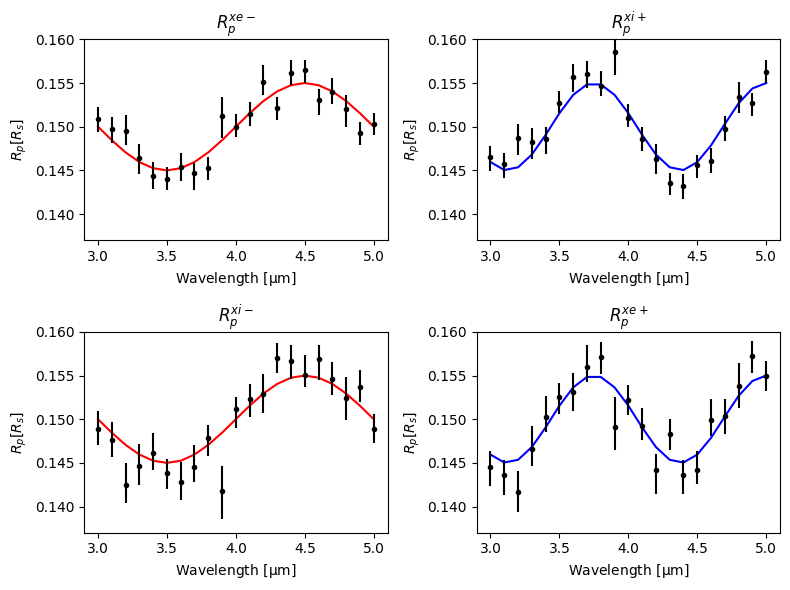

In [10]:
rp_input = [[rp_over_rs_evening, rp_over_rs_morning], [rp_over_rs_evening, rp_over_rs_morning]]
color = [["red", "blue"], ["red", "blue"]]
directions = [["$R_{p}^{xe-}$", "$R_{p}^{xi+}$"], ["$R_{p}^{xi-}$", "$R_{p}^{xe+}$"]]

rp_xip_median = np.median(rp_xip, axis=0)
rp_xip_hpdi = hpdi(rp_xip, 0.68)
rp_xip_err = [rp_xip_median - rp_xip_hpdi[0], rp_xip_hpdi[1] - rp_xip_median]

rp_xin_median = np.median(rp_xin, axis=0)
rp_xin_hpdi = hpdi(rp_xin, 0.68)
rp_xin_err = [rp_xin_median - rp_xin_hpdi[0], rp_xin_hpdi[1] - rp_xin_median]

rp_xep_median = np.median(rp_xep, axis=0)
rp_xep_hpdi = hpdi(rp_xep, 0.68)
rp_xep_err = [rp_xep_median - rp_xep_hpdi[0], rp_xep_hpdi[1] - rp_xep_median]

rp_xen_median = np.median(rp_xen, axis=0)
rp_xen_hpdi = hpdi(rp_xen, 0.68)
rp_xen_err = [rp_xen_median - rp_xen_hpdi[0], rp_xen_hpdi[1] - rp_xen_median]

rp_4_median = [[rp_xen_median, rp_xip_median], [rp_xin_median, rp_xep_median]]
rp_4_err = [[rp_xen_err, rp_xip_err], [rp_xin_err, rp_xep_err]]

%matplotlib inline
fig = plt.figure(figsize=(8,6))
for i in range(2):
    for j in range(2):
        ax = fig.add_subplot(2, 2, i*2+j+1)
        ax.plot(
            wavelength,
            rp_input[i][j],
            color=color[i][j],
        )
        ax.errorbar(
            wavelength,
            rp_4_median[i][j],
            yerr=rp_4_err[i][j],
            color="black",
            marker=".",
            linestyle="None",
        )
        ax.set_ylim(0.137, 0.16)
        ax.set_title(directions[i][j])
        ax.set_xlabel("Wavelength [$\mathrm{\mu m}$]")
        ax.set_ylabel("$R_{p} [R_{s}]$")
plt.tight_layout()
plt.show()
plt.close()